In [1]:
import os
import pandas as pd
import numpy as np
import tacoreader
import rasterio

folder_path = '../src'
os.chdir(folder_path)
from dataset_utils.download_data import download_cloudsen12plus
from dataset_utils.evaluation import compute_metrics, visualize_results, generate_mask_s2cloudless
from dataset_utils.fmask import generate_mask_fmask

In [2]:
# Baixar os dados (caso ainda não estejam baixados)
parts = download_cloudsen12plus(local_dir="../data/dados", type="L1C")
print("Arquivos baixados:", parts)

Arquivos baixados: ['..\\data\\dados\\cloudsen12-l1c.0000.part.taco', '..\\data\\dados\\cloudsen12-l1c.0004.part.taco']


In [3]:
# Carregar o dataset
ds = tacoreader.load(parts)
print("Número total de amostras:", len(ds))

Número total de amostras: 16135


In [4]:
df = pd.DataFrame(ds)
print("Colunas do DataFrame:", df.columns)

Colunas do DataFrame: Index(['internal:subfile', 'tortilla:id', 'tortilla:file_format',
       'tortilla:data_split', 'tortilla:offset', 'tortilla:length', 'stac:crs',
       'stac:geotransform', 'stac:raster_shape', 'stac:time_start',
       'stac:time_end', 'stac:centroid', 'rai:ele', 'rai:cisi', 'rai:gdp',
       'rai:hdi', 'rai:gmi', 'rai:pop', 'rai:admin0', 'rai:admin1',
       'rai:admin2', 'roi_id', 'old_roi_id', 'equi_id', 'equi_zone',
       'label_type', 's2_id', 'real_proj_shape', 's2_mean_solar_azimuth_angle',
       's2_mean_solar_zenith_angle', 'thick_percentage', 'thin_percentage',
       'cloud_shadow_percentage', 'clear_percentage'],
      dtype='object')


In [5]:
test_tdf = df[
    (df["tortilla:data_split"] == "test") &
    (df["label_type"] == "high") &
    (ds["real_proj_shape"] == 509)
]
len(test_tdf)

975

# S2cloudless

Valores únicos em pred_mask: (array([0], dtype=uint8), array([262144], dtype=int64))
Métricas calculadas:
precision_0: 1.000
recall_0: 1.000
f1_0: 1.000
iou_0: 1.000
precision_1: 0.000
recall_1: 0.000
f1_1: 0.000
iou_1: 0.000
precision_3: 0.000
recall_3: 0.000
f1_3: 0.000
iou_3: 0.000


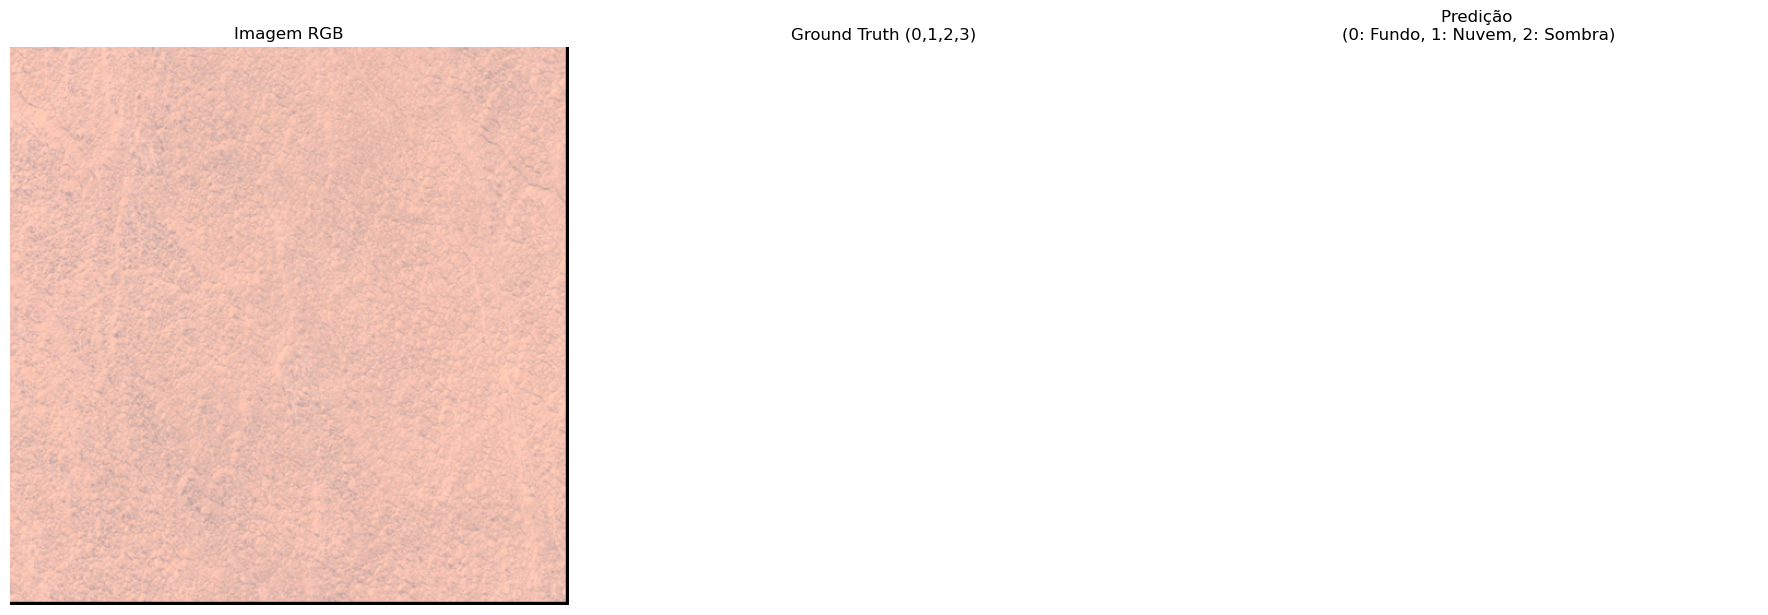

In [ ]:
# Carrega a amostra (cada linha é uma Series do pandas)
ds = tacoreader.load(parts)
index = test_tdf.index[8]
sample = ds.read(index)

# Ler o caminho do arquivo com as 13 bandas
bands_path = sample.read(0)

# Abrir com rasterio e carregar as bandas em um array NumPy
with rasterio.open(bands_path) as src_bands:
    bands_13 = src_bands.read()  # shape: (13, H, W)

# Transpor para (H, W, 13) e normalizar (opcional, mas usual para s2cloudless)
bands_13 = bands_13.transpose(1, 2, 0).astype(np.float32)
bands_13 /= 10000.0

# Gerar a máscara predita usando o algoritmo (passando o array NumPy)
pred_mask = generate_mask_s2cloudless(bands_13, threshold=0.2, avg_over=4, dil_size=2)

print("Valores únicos em pred_mask:", np.unique(pred_mask, return_counts=True))

# ---------------------------------------------------------------------------
# LER O GROUND TRUTH A PARTIR DO MESMO SAMPLE (BANDA 1)
# ---------------------------------------------------------------------------
gt_path = sample.read(1)
with rasterio.open(gt_path) as src_gt:
    gt_array = src_gt.read(1)  # shape: (H, W), valores em {0,1,2,3,...}

# Calcular as métricas usando a função compute_metrics(gt_array, pred_mask)
metrics = compute_metrics(gt_array, pred_mask)
print("Métricas calculadas:")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# Visualizar a imagem RGB, a ground truth e a predição
# (visualize_results precisa do sample para saber de onde ler as bandas, e do pred_mask)
visualize_results(sample, pred_mask, _)


In [7]:
import numpy as np
import rasterio

all_metrics = {
    "precision_0": [],
    "recall_0":    [],
    "f1_0":        [],
    "iou_0":       [],
    "precision_1": [],
    "recall_1":    [],
    "f1_1":        [],
    "iou_1":       [],
}

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
average_overs = [1, 2, 3, 4, 5]
dilation_sizes = [1, 2, 3, 4, 5]

for idx in test_tdf.index:
    # sample é um objeto TACO, de onde você obtém:
    #   - sample.read(0) -> caminho ou subfile das bandas
    #   - sample.read(1) -> caminho ou subfile da máscara
    
    sample = ds.read(idx)

    # Ler as 13 bandas
    bands_path = sample.read(0)  # caminho (ou algo que rasterio consegue abrir)
    with rasterio.open(bands_path) as src_bands:
        bands_13 = src_bands.read()  # shape: (13, H, W), dtype=uint16
    # Transpor e normalizar (se desejar 0..1)
    bands_13 = bands_13.transpose(1, 2, 0)  # (H, W, 13)
    bands_13 = bands_13.astype(np.float32) / 10000.0

    # Ler a máscara/ground truth
    mask_path = sample.read(1)
    with rasterio.open(mask_path) as src_mask:
        gt_array = src_mask.read(1)  # shape: (H, W), {0,1,2,3}

    unique_vals = np.unique(gt_array)
    print(f"\nImagem {idx} - Valores únicos na GT: {unique_vals}")

    # Verificar se existe classe 1 (nuvem)
    if not np.any(gt_array == 1):
        print(f"Imagem {idx} - Ground truth sem nuvem, ignorando.")
        continue

    # Loop de hiperparâmetros
    best_iou_1 = -1
    best_metrics = None

    for t in thresholds:
        for ao in average_overs:
            for d in dilation_sizes:
                # Gerar máscara de nuvem predita
                pred_mask = generate_mask_s2cloudless(bands_13, t, ao, d)
                # Calcular métricas
                metrics = compute_metrics(gt_array, pred_mask)

                # Comparar iou_1 para decidir melhor
                if metrics["iou_1"] > best_iou_1:
                    best_iou_1 = metrics["iou_1"]
                    best_metrics = metrics

    print(f"Imagem {idx} - Melhor iou_1={best_iou_1:.3f}")
    for k, v in best_metrics.items():
        all_metrics[k].append(v)

# Ao final, média das métricas
mean_metrics = {k: sum(v) / len(v) for k, v in all_metrics.items()}
print("\nMédia das métricas (usando melhor hiperparâmetro para cada imagem COM nuvem):")
for k, v in mean_metrics.items():
    print(f"{k}: {v:.3f}")


Imagem 1498 - Valores únicos na GT: [0 1 3]
Imagem 1498 - Melhor iou_1=0.608

Imagem 1499 - Valores únicos na GT: [0 1 3]
Imagem 1499 - Melhor iou_1=0.674

Imagem 1500 - Valores únicos na GT: [0]
Imagem 1500 - Ground truth sem nuvem, ignorando.

Imagem 1501 - Valores únicos na GT: [0 1 2 3]
Imagem 1501 - Melhor iou_1=0.000

Imagem 1502 - Valores únicos na GT: [0 1 2 3]
Imagem 1502 - Melhor iou_1=0.475

Imagem 1503 - Valores únicos na GT: [0 1 3]
Imagem 1503 - Melhor iou_1=0.713

Imagem 1504 - Valores únicos na GT: [0 1 3]
Imagem 1504 - Melhor iou_1=0.883

Imagem 1505 - Valores únicos na GT: [0 1 3]
Imagem 1505 - Melhor iou_1=0.873

Imagem 1506 - Valores únicos na GT: [0]
Imagem 1506 - Ground truth sem nuvem, ignorando.

Imagem 1507 - Valores únicos na GT: [0 1 3]
Imagem 1507 - Melhor iou_1=0.757

Imagem 1508 - Valores únicos na GT: [0 1 3]
Imagem 1508 - Melhor iou_1=0.952

Imagem 1509 - Valores únicos na GT: [0 1 3]
Imagem 1509 - Melhor iou_1=0.805

Imagem 1510 - Valores únicos na GT:

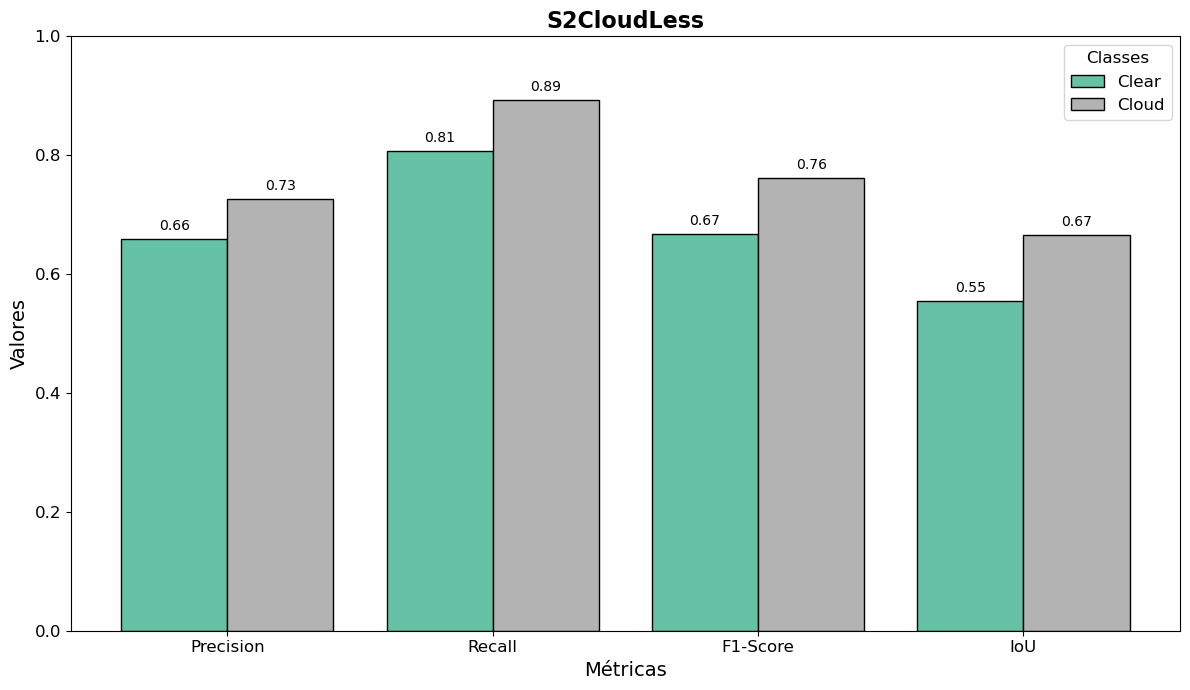

In [8]:
import matplotlib.pyplot as plt

# Separar os valores (Clear = classe 0) e (Cloud = classe 1)
clear_values = [
    mean_metrics["precision_0"],
    mean_metrics["recall_0"],
    mean_metrics["f1_0"],
    mean_metrics["iou_0"]
]
cloud_values = [
    mean_metrics["precision_1"],
    mean_metrics["recall_1"],
    mean_metrics["f1_1"],
    mean_metrics["iou_1"]
]

# Rótulos das métricas
metric_labels = ["Precision", "Recall", "F1-Score", "IoU"]

# Cria o eixo X com base na quantidade de métricas
x = np.arange(len(metric_labels))

# Largura de cada barra
width = 0.4

fig, ax = plt.subplots(figsize=(12, 7))

# Define cores usando a paleta Set2 para manter o mesmo estilo
colors = plt.cm.Set2(np.linspace(0, 1, 2))

# Gráfico de barras (Clear) com borda preta
rects_clear = ax.bar(x - width/2, clear_values, width,
                     label="Clear", color=colors[0], edgecolor='black')
# Gráfico de barras (Cloud) com borda preta
rects_cloud = ax.bar(x + width/2, cloud_values, width,
                     label="Cloud", color=colors[1], edgecolor='black')

# Ajusta os rótulos no eixo X com tamanho de fonte consistente
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=12)

# Define o limite do eixo Y
ax.set_ylim(0, 1)

# Configurações dos rótulos e título com o mesmo estilo
ax.set_xlabel("Métricas", fontsize=14)
ax.set_ylabel("Valores", fontsize=14)
ax.set_title("S2CloudLess", fontsize=16, weight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.legend(title="Classes", fontsize=12, title_fontsize=12)

# Função para adicionar os rótulos de valor no topo de cada barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,
            height + 0.01,
            f"{height:.2f}",
            ha='center', va='bottom', fontsize=10
        )

autolabel(rects_clear)
autolabel(rects_cloud)

plt.tight_layout()
plt.show()

# Fmask

Valores únicos em cloud_mask: (array([0, 1], dtype=uint8), array([192816,  69328], dtype=int64))
Valores únicos em shadow_mask: (array([0, 1], dtype=uint8), array([238659,  23485], dtype=int64))
Métricas calculadas:
precision_0: 0.293
recall_0: 0.994
f1_0: 0.452
iou_0: 0.292
precision_1: 0.997
recall_1: 0.513
f1_1: 0.678
iou_1: 0.513
precision_3: 0.888
recall_3: 0.268
f1_3: 0.412
iou_3: 0.259


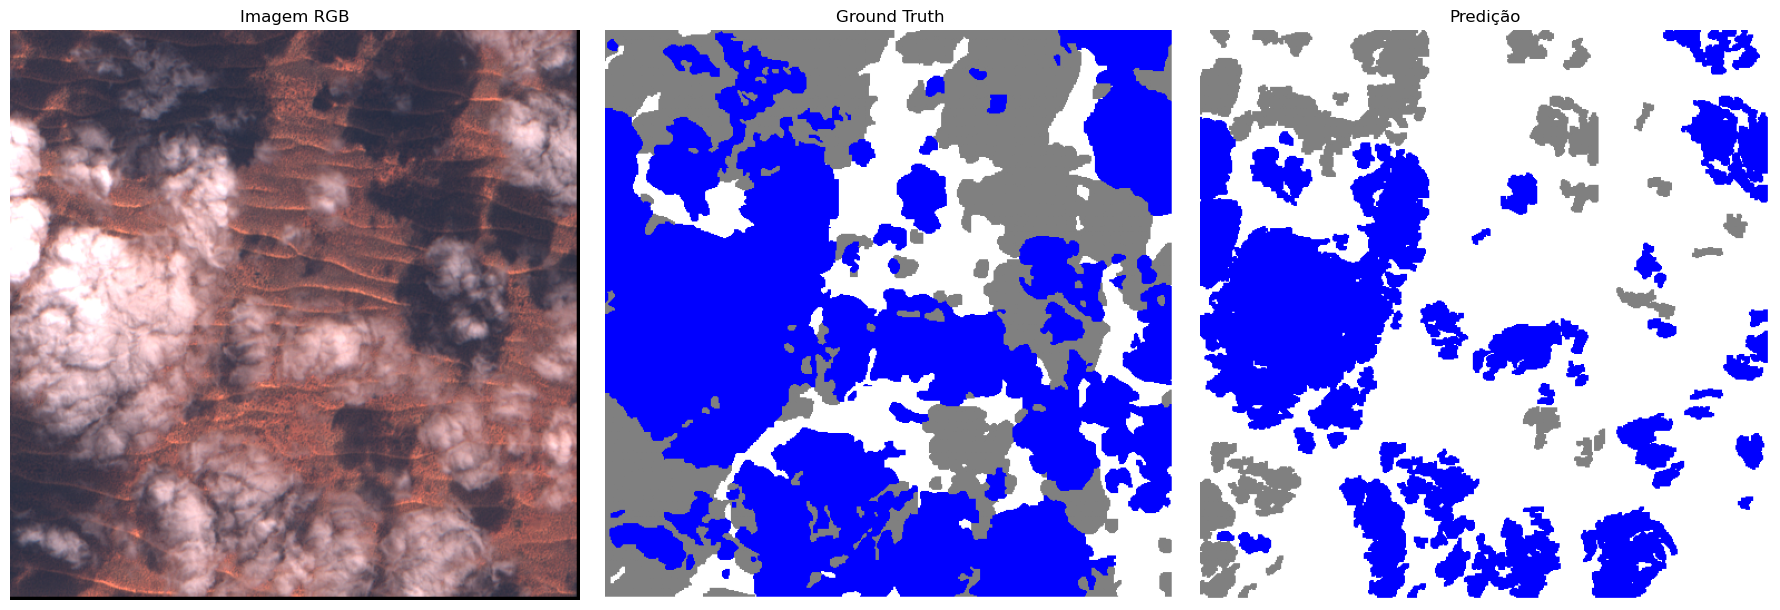

In [6]:
ds = tacoreader.load(parts)
index = test_tdf.index[0]
sample = ds.read(index)

# Extrair os ângulos solares da tabela
angle_zenith  = test_tdf["s2_mean_solar_zenith_angle"][index]
angle_azimuth = test_tdf["s2_mean_solar_azimuth_angle"][index]

# Ler as bandas (banda 0) e convertê-las para um array NumPy
bands_path = sample.read(0)
with rasterio.open(bands_path) as src:
    bands = src.read()  # shape: (N, H, W)

bands = bands.transpose(1, 2, 0).astype(np.float32)
bands /= 10000.0  # Normalização para reflectância [0,1]

# Gerar as máscaras preditas usando a função otimizada em memória
# Agora a função 'generate_mask_fmask' retorna (cloud_mask, shadow_mask)
cloud_mask, shadow_mask = generate_mask_fmask(
    bands, angle_zenith, angle_azimuth
)

print("Valores únicos em cloud_mask:", np.unique(cloud_mask, return_counts=True))
print("Valores únicos em shadow_mask:", np.unique(shadow_mask, return_counts=True))

# Ler a ground truth (banda 1)
gt_path = sample.read(1)
with rasterio.open(gt_path) as src_gt:
    gt_array = src_gt.read(1)  # shape: (H, W)

# ----------------------------------------------------------
# Montar a predição 3-classes: 0=clear, 1=cloud, 3=shadow
# ----------------------------------------------------------
pred_3class = np.zeros_like(cloud_mask, dtype=np.uint8)
pred_3class[cloud_mask == 1]  = 1
pred_3class[shadow_mask == 1] = 3

# Calcular métricas para as classes 0,1,3 (classe 2 é thin cloud e está sendo ignorada)
metrics = compute_metrics(gt_array, pred_3class)
print("Métricas calculadas:")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# Visualizar resultados
visualize_results(sample, cloud_mask, shadow_mask)

In [14]:
import numpy as np
import random
import rasterio

# Exemplo de dicionário para armazenar métricas das 3 classes:
all_metrics = {
    "precision_0": [],
    "recall_0":    [],
    "f1_0":        [],
    "iou_0":       [],
    "precision_1": [],
    "recall_1":    [],
    "f1_1":        [],
    "iou_1":       [],
    "precision_3": [],
    "recall_3":    [],
    "f1_3":        [],
    "iou_3":       [],
}

# Função auxiliar para sortear um valor de uma lista ou intervalo
def sample_choice(parameter_list):
    return random.choice(parameter_list)

# Parâmetros de busca
shadow_thresholds       = [0.10, 0.12, 0.15, 0.18, 0.20, 0.25]
whiteness_thresholds    = [0.20, 0.30, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
brightness_thresholds   = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
swir2_thresholds        = [0.05, 0.07, 0.09, 0.10, 0.12, 0.15, 0.20]
ndvi_thresholds         = [0.15, 0.20, 0.30, 0.40, 0.50, 0.60]
ndsi_thresholds         = [0.15, 0.20, 0.30, 0.40, 0.50, 0.60]
min_sizes               = [3, 5, 10, 20, 50, 100, 200]
dilate_iterations_list  = [0, 1, 2, 3, 4, 5]
cloud_heights           = [1000, 2000, 3000, 4000, 5000]

# Número de amostras aleatórias a testar por imagem
N_RANDOM_SAMPLES = 500  

# Loop sobre as imagens
for idx in test_tdf.index:
    sample = ds.read(idx)

    # ----------------------------------------------------------
    # Ler ground truth original (banda 1) em {0,1,2,3}
    # ----------------------------------------------------------
    # 0: Clear
    # 1: Thick cloud
    # 2: Thin cloud
    # 3: Shadow
    gt_path = sample.read(1)
    with rasterio.open(gt_path) as src_mask:
        gt_array = src_mask.read(1)  # shape: (H, W), {0,1,2,3}

    unique_vals = np.unique(gt_array)
    print(f"\nImagem {idx} - Valores GT originais: {unique_vals}")

    # Verificar se existe classe 1 (thick cloud) na imagem
    if not np.any(gt_array == 1):
        print(f"Imagem {idx} - Ground truth sem thick cloud (classe 1). Ignorando.")
        continue

    # ----------------------------------------------------------
    # Ler bandas S2
    # ----------------------------------------------------------
    bands_path = sample.read(0)
    with rasterio.open(bands_path) as src_bands:
        all_bands = src_bands.read()  # shape: (13, H, W)

    # Transpor e normalizar
    all_bands = all_bands.transpose(1, 2, 0).astype(np.float32)
    all_bands /= 10000.0

    angle_zenith  = test_tdf["s2_mean_solar_zenith_angle"][idx]
    angle_azimuth = test_tdf["s2_mean_solar_azimuth_angle"][idx]

    best_score    = -1.0
    best_metrics  = {}
    best_params   = None

    # ----------------------------------------------------------
    # Random Search
    # ----------------------------------------------------------
    for _ in range(N_RANDOM_SAMPLES):
        # Sorteia valores de cada hiperparâmetro
        st  = sample_choice(shadow_thresholds)
        wt  = sample_choice(whiteness_thresholds)
        bt  = sample_choice(brightness_thresholds)
        sw2 = sample_choice(swir2_thresholds)
        ndv = sample_choice(ndvi_thresholds)
        nds = sample_choice(ndsi_thresholds)
        ms  = sample_choice(min_sizes)
        di  = sample_choice(dilate_iterations_list)
        ch  = sample_choice(cloud_heights) 

        # Gera máscaras usando a função de predição 
        pred_cloud, pred_shadow = generate_mask_fmask(
            bands_13=all_bands,
            angle_zenith=angle_zenith,
            angle_azimuth=angle_azimuth,
            shadow_threshold=st,
            whiteness_threshold=wt,
            brightness_threshold=bt,
            swir2_thresh=sw2,
            ndvi_thresh=ndv,
            ndsi_thresh=nds,
            min_size=ms,
            dilate_iterations=di,
            cloud_height=ch  # passando o cloud height para a função
        )

        # 3 classes na predição: 0=clear, 1=cloud, 3=shadow
        pred_3class_mask = np.zeros_like(pred_cloud, dtype=np.uint8)
        pred_3class_mask[pred_cloud == 1]  = 1
        pred_3class_mask[pred_shadow == 1] = 3

        # Métricas (ignoram a classe 2 do GT)
        metrics = compute_metrics(gt_array, pred_3class_mask)

        # Ajustar o cálculo do score para a classe shadow:
        # Se a imagem não possui pixels de sombra no GT, define o IoU de sombra como NaN
        # e utiliza apenas o IoU da nuvem para o score.
        iou_1 = metrics.get("iou_1", 0.0)
        iou_3 = metrics.get("iou_3", 0.0)
        if not np.any(gt_array == 3):
            metrics["iou_3"] = np.nan  # Define como NaN se não houver sombra na GT
            score = iou_1
        else:
            score = iou_1 + iou_3

        if score > best_score:
            best_score   = score
            best_metrics = metrics
            # Atualizando os parâmetros para incluir o cloud height
            best_params  = (st, wt, bt, sw2, ndv, nds, ms, di, ch)

    # ----------------------------------------------------------
    # Melhor resultado para essa imagem
    # ----------------------------------------------------------
    if best_params is not None:
        print(
            f"Imagem {idx} - Melhor score (iou_1 + iou_3)={best_score:.3f} com:\n"
            f" shadow={best_params[0]}, whiteness={best_params[1]}, brightness={best_params[2]},\n"
            f" swir2={best_params[3]}, ndvi={best_params[4]}, ndsi={best_params[5]},\n"
            f" min_size={best_params[6]}, dilate={best_params[7]}, cloud height={best_params[8]}"
        )
        for k, v in best_metrics.items():
            if k in all_metrics:
                all_metrics[k].append(v)
    else:
        print(f"Imagem {idx} - Não encontrou parâmetros melhores ou não havia classe 1 na GT.")

# -----------------------------------------------------------------
# Média das métricas finais
# -----------------------------------------------------------------
mean_metrics = {}
for k, vals in all_metrics.items():
    if len(vals) > 0:
        if k == "iou_3":
            # Usa np.nanmean para ignorar valores NaN
            mean_metrics[k] = np.nanmean(vals)
        else:
            mean_metrics[k] = np.mean(vals)
    else:
        mean_metrics[k] = 0.0

print("\nMédia das métricas (usando melhor hiperparâmetro para cada imagem):")
for k, v in mean_metrics.items():
    print(f"{k}: {v:.3f}")


Imagem 1498 - Valores GT originais: [0 1 3]
Imagem 1498 - Melhor score (iou_1 + iou_3)=1.330 com:
 shadow=0.18, whiteness=0.6, brightness=0.1,
 swir2=0.09, ndvi=0.5, ndsi=0.2,
 min_size=3, dilate=4, cloud height=1000

Imagem 1499 - Valores GT originais: [0 1 3]
Imagem 1499 - Melhor score (iou_1 + iou_3)=1.202 com:
 shadow=0.15, whiteness=0.55, brightness=0.15,
 swir2=0.07, ndvi=0.4, ndsi=0.6,
 min_size=10, dilate=4, cloud height=3000

Imagem 1500 - Valores GT originais: [0]
Imagem 1500 - Ground truth sem thick cloud (classe 1). Ignorando.

Imagem 1501 - Valores GT originais: [0 1 2 3]
Imagem 1501 - Melhor score (iou_1 + iou_3)=0.000 com:
 shadow=0.2, whiteness=0.4, brightness=0.15,
 swir2=0.1, ndvi=0.15, ndsi=0.4,
 min_size=50, dilate=2, cloud height=1000

Imagem 1502 - Valores GT originais: [0 1 2 3]
Imagem 1502 - Melhor score (iou_1 + iou_3)=0.550 com:
 shadow=0.2, whiteness=0.4, brightness=0.2,
 swir2=0.07, ndvi=0.2, ndsi=0.6,
 min_size=200, dilate=3, cloud height=5000

Imagem 1503

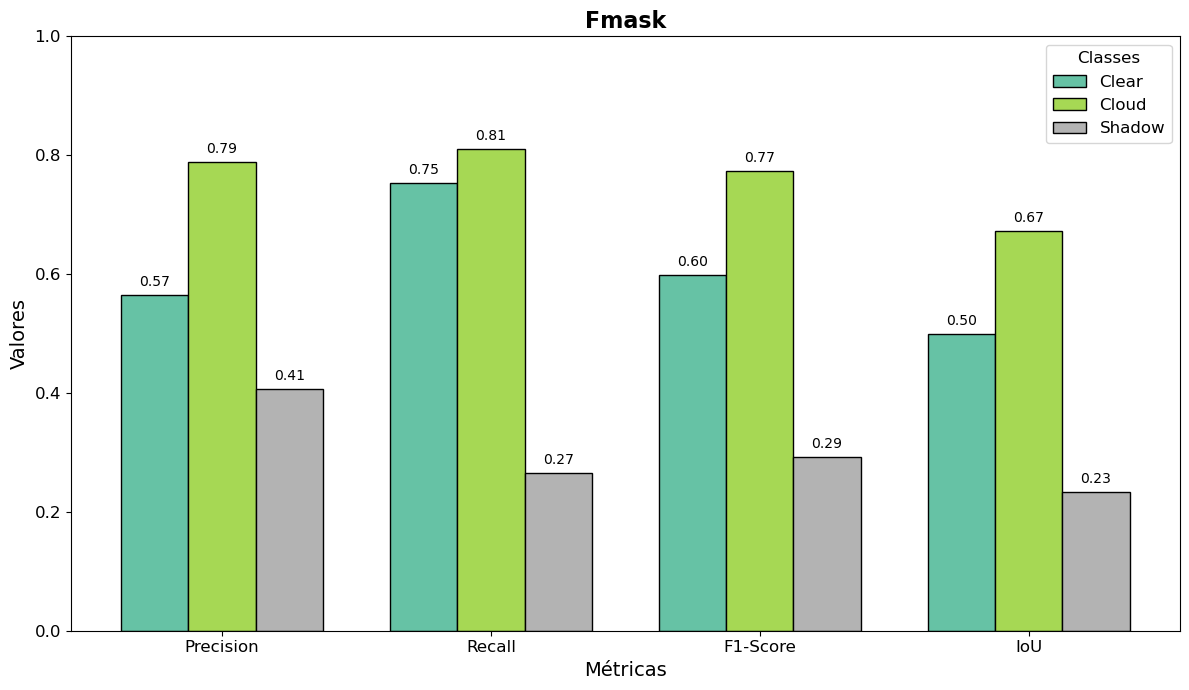

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1) Coleta de valores das métricas
# -------------------------------
# mean_metrics é o dicionário com as médias finais (precision_0, recall_0, etc.)

# Classe 0 => Clear
clear_values = [
    mean_metrics["precision_0"],
    mean_metrics["recall_0"],
    mean_metrics["f1_0"],
    mean_metrics["iou_0"]
]
# Classe 1 => Cloud
cloud_values = [
    mean_metrics["precision_1"],
    mean_metrics["recall_1"],
    mean_metrics["f1_1"],
    mean_metrics["iou_1"]
]
# Classe 2 => Shadow (se você quiser exibir)
shadow_values = [
    mean_metrics["precision_3"],
    mean_metrics["recall_3"],
    mean_metrics["f1_3"],
    mean_metrics["iou_3"]
]

# Rótulos das métricas
metric_labels = ["Precision", "Recall", "F1-Score", "IoU"]
x = np.arange(len(metric_labels))  # posições no eixo X

# -------------------------------
# 2) Parâmetros de plot
# -------------------------------
width = 0.25  # Largura de cada barra
fig, ax = plt.subplots(figsize=(12, 7))

# Vamos usar 3 cores de um colormap, por exemplo 'Set2'
colors = plt.cm.Set2(np.linspace(0, 1, 3))

# -------------------------------
# 3) Plotando cada classe
# -------------------------------
# Clear (classe 0)
rects_clear = ax.bar(
    x - width,              # desloca para esquerda
    clear_values,
    width,
    label="Clear",
    color=colors[0],
    edgecolor="black"
)
# Cloud (classe 1)
rects_cloud = ax.bar(
    x,                      # sem deslocamento
    cloud_values,
    width,
    label="Cloud",
    color=colors[1],
    edgecolor="black"
)
# Shadow (classe 2)
rects_shadow = ax.bar(
    x + width,              # desloca para direita
    shadow_values,
    width,
    label="Shadow",
    color=colors[2],
    edgecolor="black"
)

# -------------------------------
# 4) Customizações do gráfico
# -------------------------------
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=12)
ax.set_ylim(0, 1)  # As métricas variam de 0 a 1

ax.set_xlabel("Métricas", fontsize=14)
ax.set_ylabel("Valores", fontsize=14)
ax.set_title("Fmask", fontsize=16, weight="bold")
ax.tick_params(axis='y', labelsize=12)

ax.legend(title="Classes", fontsize=12, title_fontsize=12)

# Função para adicionar rótulos (valores) no topo das barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,
            height + 0.01,
            f"{height:.2f}",
            ha="center", va="bottom", fontsize=10
        )

autolabel(rects_clear)
autolabel(rects_cloud)
autolabel(rects_shadow)

plt.tight_layout()
plt.show()